In [2]:
import numpy as np 
import gym
import minihack 
from minihack import RewardManager
from nle import nethack 

import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image as pil

import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2 as cv

from IPython.display import display, clear_output

In [3]:
device = torch.device("cuda")

In [4]:
# format glyphs and messages for learning
def format_observation(obs):
    
    # reshape glyphs
    glyphs = obs["glyphs"]
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    
    # reshape messages
    message = obs["message"]
    if obs["message"].max()>0: 
        message = message/message.max()
    message = message.reshape((1,len(message)))
    
    obs = {"glyphs":glyphs,"message":message}

    return obs

In [5]:
# # compute the normalised discounted returns 
def compute_returns(rewards, gamma):
    returns_list = []
    single_return = 0
    for reward in rewards[::-1]:
        single_return = reward + gamma*single_return
        returns_list.append(single_return)
    
    returns_list.reverse()
    returns = np.array(returns_list)
    
    # normalize returns
    if np.mean(returns)!= 0:
         returns = returns-np.mean(returns)
    if np.std(returns) != 0:
        returns = returns/np.std(returns)

    return returns

In [6]:
class A2C(nn.Module):

    def __init__(self,s_size=8,h_size=128,action_size=4):
        
        super(A2C, self).__init__()
        
        # Convolutional layer
        self.convolution_1 = nn.Conv2d(in_channels=1, out_channels=20,kernel_size=(5, 5))
        self.relu_1 = nn.ReLU()
        self.maxpool_1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Convolutional layer 
        self.convolution_2 = nn.Conv2d(in_channels=20, out_channels=50,kernel_size=(5, 5))
        self.relu_2 = nn.ReLU()
        self.maxpool_2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # dense layers for extracted glyph features
        self.dense_1 = nn.Linear(in_features=1600, out_features=500)
        self.relu_3 = nn.ReLU()
        self.dense_2 = nn.Linear(in_features=500, out_features=128)
        self.relu_4 = nn.ReLU()
        
        # dense layer for messages
        self.dense_3 = nn.Linear(in_features=256, out_features=128)
        self.relu_5 = nn.ReLU()
        
        # dense for glyphs features and messages 
        self.dense_4 = nn.Linear(in_features=256, out_features=128)
        self.relu_6 = nn.ReLU()

        # actor critic specific layers
        self.value_layer = nn.Linear(in_features=128, out_features=1)
        self.action_layer = nn.Linear(in_features=128, out_features=action_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, obs):
        
        obs_glyphs  = torch.from_numpy(obs["glyphs"]).float().to(device)
        obs_message  = torch.from_numpy(obs["message"]).float().to(device)

        # propagate glyphs through CNN layers and then flatten
        obs_glyphs = self.convolution_1(obs_glyphs)
        obs_glyphs = self.relu_1(obs_glyphs)
        obs_glyphs = self.maxpool_1(obs_glyphs)
        obs_glyphs = self.convolution_2(obs_glyphs)
        obs_glyphs = self.relu_2(obs_glyphs)
        obs_glyphs = self.maxpool_2(obs_glyphs)
        obs_glyphs = obs_glyphs.reshape(obs_glyphs.shape[0], -1)
        # run extracted glyphs features through dense layers
        obs_glyphs = self.dense_1(obs_glyphs)
        obs_glyphs = self.relu_3(obs_glyphs)
        obs_glyphs = self.dense_2(obs_glyphs)
        obs_glyphs = self.relu_4(obs_glyphs)
        # run message through dense layers
        obs_message = self.dense_3(obs_message)
        obs_message = self.relu_5(obs_message)
        # merge features
        combined = torch.cat((obs_glyphs,obs_message),1)
        # run merged featured through dense layer
        combined = self.dense_4(combined)
        combined = self.relu_6(combined)

        state_value = self.value_layer(combined)
        action_probs = self.action_layer(combined)

        action_probs = self.softmax(action_probs)

        return action_probs,state_value

In [7]:
def train_a2c(env, learning_rate, num_episodes, gamma):

    model = A2C(h_size=512, action_size=env.action_space.n).to(device)
   
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # store the returns in each episode 
    returns =[]

    steps = 0

    for i in range(num_episodes):
        
        state = format_observation(env.reset())

        done = False
        
        # store the rewards acquired, the log_probability of the actions and
        # the value function of the states visited in this episode 
        rewards = []
        log_probs = []
        values = []
        
        while not done:
            
            # Run actor critic and return value and policy action distribution
            policy_dist, value = model.forward(state)
            dist = torch.distributions.Categorical(policy_dist)

            # Choose an action and execute the action 
            action = dist.sample()
            new_state, reward, done, _ = env.step(action.item())
    
            # append rewards, values, log_probs to their lists and update state
            rewards.append(reward)
            log_probs.append(dist.log_prob(action))
            values.append(value)
            
            state = format_observation(new_state)
            steps+=1

        # Store the reward acquired in the episode and calculate the discounted return of the episode
        returns.append(np.sum(rewards))
        disc_returns = compute_returns(rewards, gamma)
        disc_returns = torch.from_numpy(disc_returns).float().to(device)
        
        if len(disc_returns) % 50 == 0:
            print(f"Episode: {i} 50 episode ave. return:{np.mean(returns[-50:])}")

        # update actor critic
        loss = 0
        for log_prob,value,reward in zip(log_probs, values, disc_returns):
            advantage = reward-value.item()
            actor_loss = -log_prob*advantage
            try:
                reward = reward.resize(1,1)
            except:
                pass
            critic_loss = F.smooth_l1_loss(value, reward)
            net_loss = actor_loss + critic_loss
            loss += net_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
    return model, returns

### Training 

In [8]:

from minihack import RewardManager

moves = tuple(nethack.CompassDirection)
abilities = (
    # open the closed doors
    nethack.Command.OPEN,
    # pick-up item since autopickup is disabled
    nethack.Command.PICKUP,
    # actions for items to deal with lava
    # drink potions
    nethack.Command.QUAFF,
    # put on ring
    nethack.Command.PUTON,
    # wear boots
    nethack.Command.WEAR,
    # apply horn
    nethack.Command.APPLY,

    # zap wand
    nethack.Command.ZAP,
    # press f
    nethack.Command.FIRE,
    # Press g
    nethack.Command.RUSH,
    # press r
    nethack.Command.READ,
    # press y
    ord("y")
)
action_space = moves + abilities
# Custom rewards manager for rewards shaping
reward_manager = RewardManager()

# pick up reward
pick_up_msgs_0 = ["f - a"]
pick_up_msgs_1 = ["g - a"]
reward_manager.add_message_event(pick_up_msgs_0, reward=0.7, repeatable=False)
reward_manager.add_message_event(pick_up_msgs_1, reward=0.7, repeatable=False)

# levitation reward
levitate_msgs = ["You start to float in the air!", "a ring of levitation (on right hand)."]
reward_manager.add_message_event(levitate_msgs, reward=0.8, repeatable=False)

# freezing lava reward
freeze_msgs = ["The lava cools and solidifies."]
reward_manager.add_message_event(freeze_msgs, reward=0.8, repeatable=True)

# kill minotaur reward
kill_msgs = ["You kill the minotaur!"]
reward_manager.add_message_event(kill_msgs, reward=0.9, repeatable=False)
# Maze solved reward
door_msg = ["The door opens."]
reward_manager.add_message_event(door_msg, reward=0.6, terminal_sufficient=False, repeatable=False)

# Penalty for walking into walls
msgs = ["It's a wall."]
reward_manager.add_message_event(msgs, reward=-0.01, terminal_sufficient=False, repeatable=True)

env = gym.make(
    "MiniHack-Quest-Hard-v0",
    observation_keys=(["glyphs", "inv_glyphs", "pixel", "message"]),
    reward_manager=reward_manager,
    reward_win=1,
    reward_lose =0,
    penalty_mode="constant",
    penalty_step= 0,
    penalty_time = -0.01,
    actions=action_space,
)

learning_rate=0.02
number_episodes=1000
gamma=0.99

/home/wakawaka/.virtualenvs/hons/lib/python3.8/site-packages/minihack/scripts/mh_patch_nhdat.sh: line 25: cd: too many arguments


In [ ]:

model, scores = train_a2c(env,learning_rate,number_episodes, gamma)

torch.save(model.state_dict(), "models/agent_trained_a2c.pt")

np.savez("scores", np.array(scores))

### Results

1000


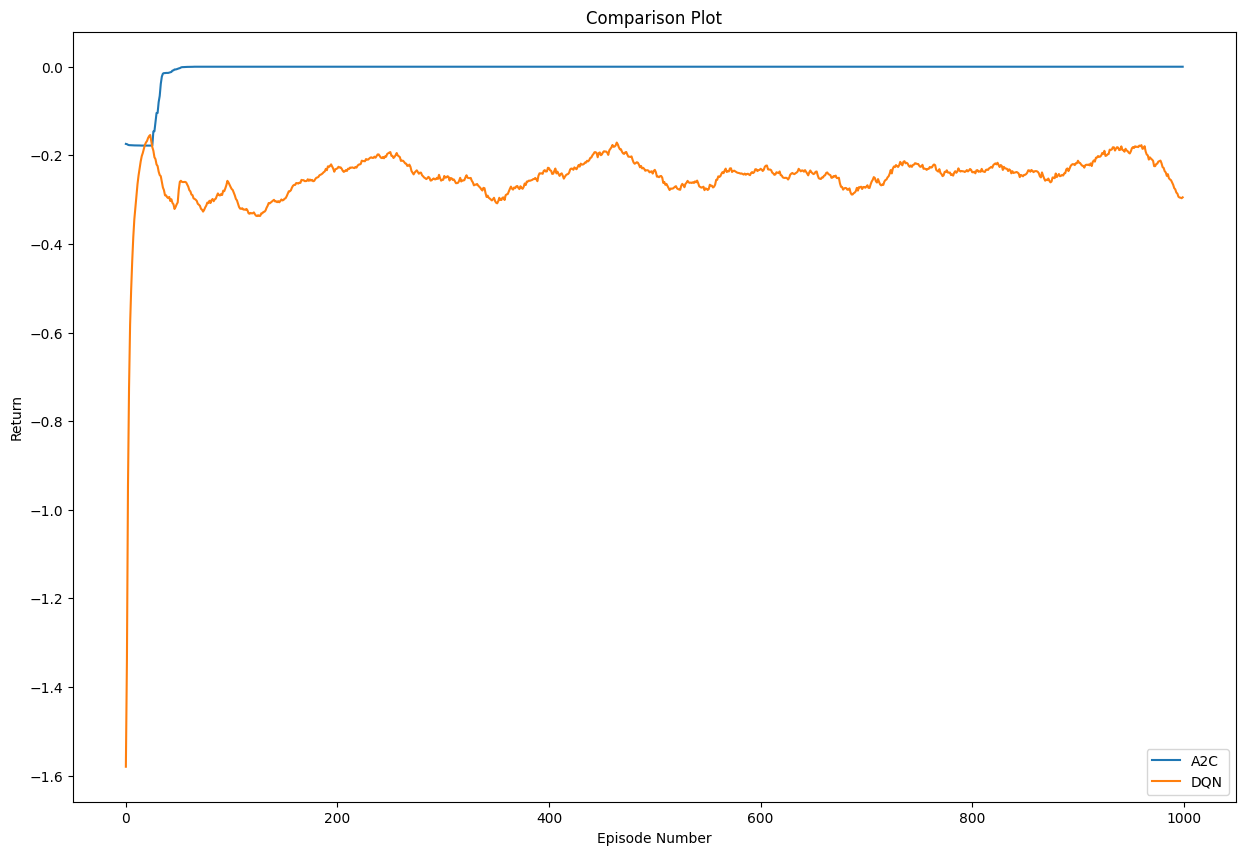

In [10]:

results_file = np.load("scores.npz")

dqn_results_file = np.load('DQN_results_np.npz')

results = results_file["arr_0"]

print(len(results))

dqn_results_ave = dqn_results_file["arr_1"]

plt.figure(figsize=(15,10))

results_ave = np.convolve(results, np.ones((50,))/50, mode='same') 

# Plot individual iterations 

plt.plot(results_ave)
plt.plot(dqn_results_ave)

plt.legend(['A2C', 'DQN'])

plt.title(f"Comparison Plot")
plt.xlabel("Episode Number")
plt.ylabel("Return")
plt.savefig("comparison.png")
plt.show()

### Testing

In [12]:
agent = A2C(h_size=512, action_size=env.action_space.n).to(device)
agent.load_state_dict(torch.load("models/agent_trained_a2c.pt"))
agent.eval()


moves = tuple(nethack.CompassDirection)
abilities = (
    # open the closed doors
    nethack.Command.OPEN,
    # pick-up item since autopickup is disabled
    nethack.Command.PICKUP,
    # actions for items to deal with lava
    # drink potions
    nethack.Command.QUAFF,
    # put on ring
    nethack.Command.PUTON,
    # wear boots
    nethack.Command.WEAR,
    # apply horn
    nethack.Command.APPLY,

    # zap wand
    nethack.Command.ZAP,
    # press f
    nethack.Command.FIRE,
    # Press g
    nethack.Command.RUSH,
    # press r
    nethack.Command.READ,
    # press y
    ord("y")
)
action_space = moves + abilities
# Custom rewards manager for rewards shaping
reward_manager = RewardManager()

# pick up reward
pick_up_msgs_0 = ["f - a"]
pick_up_msgs_1 = ["g - a"]
reward_manager.add_message_event(pick_up_msgs_0, reward=0.7, repeatable=False)
reward_manager.add_message_event(pick_up_msgs_1, reward=0.7, repeatable=False)

# levitation reward
levitate_msgs = ["You start to float in the air!", "a ring of levitation (on right hand)."]
reward_manager.add_message_event(levitate_msgs, reward=0.8, repeatable=False)

# freezing lava reward
freeze_msgs = ["The lava cools and solidifies."]
reward_manager.add_message_event(freeze_msgs, reward=0.8, repeatable=True)

# kill minotaur reward
kill_msgs = ["You kill the minotaur!"]
reward_manager.add_message_event(kill_msgs, reward=0.9, repeatable=False)
# Maze solved reward
door_msg = ["The door opens."]
reward_manager.add_message_event(door_msg, reward=0.6, terminal_sufficient=False, repeatable=False)

# Penalty for walking into walls
msgs = ["It's a wall."]
reward_manager.add_message_event(msgs, reward=-0.01, terminal_sufficient=False, repeatable=True)

test_env = gym.make(
    "MiniHack-Quest-Hard-v0",
    observation_keys=(["glyphs", "inv_glyphs", "pixel", "message"]),
    reward_manager=reward_manager,
    reward_win=1,
    reward_lose =0,
    penalty_mode="constant",
    penalty_step= 0,
    penalty_time = -0.01,
    actions=action_space,
)


def get_frame(obs):
    return obs["pixel"]

        
def get_frame_title(obs):
    message = bytes(obs['message'])
    title = ""
    message = message[: message.index(b"\0")].decode("utf-8")
    title += "MESSAGE: " + message

    return title

def print_message(obs):
    message = bytes(obs['message'])
    title = ""
    message = message[: message.index(b"\0")].decode("utf-8")
    print(message)

    return title


obs = test_env.reset()
frames = []
done = False
frames.append(obs["pixel"])
title = get_frame_title(obs)

# plt.ion()
# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,10))
# ax.axis('off')


# ax.set_title(title)
# im  = ax.imshow(get_frame(obs))
# display(fig)

while not done:

    # uncomment to view playthrough
    # plt.pause(0.1)

    obs = format_observation(obs)

    with torch.no_grad():
        # Run actor critic and return value and policy action distribution
        policy_dist, value = agent.forward(obs)

    dist = torch.distributions.Categorical(policy_dist)

    # Choose an action and execute the action 
    action = dist.sample()
    next_observation, reward, done, _ = test_env.step(action.item())
    

    title = get_frame_title(next_observation)
    
    #add the reward to the title
    # print(reward)
    # title += "REWARD: " + str(reward)
    # ax.set_title(title)
    # im.set_data(get_frame(next_observation))
    # fig.canvas.draw()
    # fig.canvas.flush_events()
    # clear_output()
    # display(fig)

    obs = next_observation
    frames.append(obs["pixel"])


test_env.close()


gif_frames = [pil.fromarray(frame) for frame in frames]
gif_frame = gif_frames[0]
gif_frame.save(
        "videos/game.gif",
        format="GIF",
        append_images=gif_frames,
        save_all=True,
        duration=50,
        loop=0
    )
 
frame_size = size = frames[0].shape[:2]

video = cv.VideoWriter('videos/game.mp4',cv.VideoWriter_fourcc(*'mp4v'), 4, (frame_size[1],frame_size[0]))
for frame in frames:
    video.write(cv.cvtColor(frame,cv.COLOR_RGB2BGR))


video.release()
cv.destroyAllWindows()


/home/wakawaka/.virtualenvs/hons/lib/python3.8/site-packages/minihack/scripts/mh_patch_nhdat.sh: line 25: cd: too many arguments


KeyError: 'pixel'